In [2]:
from os import listdir
from os.path import isfile, join
import pandas as pd
import numpy as np
import math
from datetime import datetime
import matplotlib.pyplot as plt
import regex as re

In [3]:
path = '.\\daily_reddit_data'
files = [f for f in listdir(path) if isfile(join(path, f))]

In [4]:
li = []
final_df = pd.DataFrame()
for file in files:
    df = pd.read_csv(path+'\\'+file)
    df = df.drop(labels = 'text',axis = 1) # dropping biggest column to prevent memory overloading
    li.append(df)
final_df = pd.concat(li)

In [5]:
final_df = final_df[final_df['text_type'].isin(['post','comment'])] #only keep rows with correct formatting
final_df.drop(final_df.iloc[:, 6:], inplace = True, axis = 1) #drop columns created due to wrong formatting
final_df = final_df.fillna('') #change NaNs to empty string
#summary statistics
print(final_df.shape)
print()
print(final_df.head())
print()
print('How much data do we have from each subreddit:')
print(final_df.groupby('subreddit')['post_id'].count()) #how much data from each subreddit
print()
print('How many comments and posts do we have:')
print(final_df.groupby('text_type')['post_id'].count()) #how much posts and comments
print()
print('How many entries contain a ticker mention from our dictionary:')
print(final_df.loc[final_df['tickers'] != '']['post_id'].count()) 

(78564, 6)

  post_id comment_id subreddit text_type  epoch_time             tickers
0  mh28u8               stocks      post  1617182413                    
1  mh28u8    gswqvmh    stocks   comment  1617194824                    
2  mh28u8    gsx8dgo    stocks   comment  1617203850  ['DISCA', 'DISCK']
3  mh28u8    gswlgsf    stocks   comment  1617191124                    
4  mh28u8    gswdnjn    stocks   comment  1617184077                    

How much data do we have from each subreddit:
subreddit
StockMarket       15946
investing         20440
stocks            20169
wallstreetbets    22009
Name: post_id, dtype: int64

How many comments and posts do we have:
text_type
comment    59805
post       18759
Name: post_id, dtype: int64

How many entries contain a ticker mention from our dictionary:
14029


In [6]:
#drop comments that are duplicates
final_df_comments = final_df.loc[final_df['text_type'] == 'comment']
final_df_comments = final_df_comments.drop_duplicates(subset = ['comment_id'])
#drop posts that are duplicates
#checkin inbetween if duplicates were removed
final_df_posts = final_df.loc[final_df['text_type'] == 'post']
print(final_df_posts.duplicated('post_id').any())
final_df_posts = final_df_posts.drop_duplicates(subset = ['post_id'])
print(final_df_posts.duplicated('post_id').any())
#concat back together
final_df = pd.concat([final_df_posts,final_df_comments])

True
False


In [7]:
#we see that some values imported as strings and some as ints, so we standardize
for i, row in final_df['epoch_time'].iteritems():
        if type(row) is not int:
            print(i, row, type(row))
final_df['epoch_time'] = pd.to_numeric(final_df['epoch_time'])

r'>
117 1620033475 <class 'str'>
121 1620052901 <class 'str'>
127 1620020659 <class 'str'>
132 1620063094 <class 'str'>
135 1620061519 <class 'str'>
179 1620039620 <class 'str'>
182 1620057622 <class 'str'>
189 1620051141 <class 'str'>
194 1619991337 <class 'str'>
199 1620046335 <class 'str'>
206 1619988405 <class 'str'>
209 1619992827 <class 'str'>
217 1619981853 <class 'str'>
222 1619984165 <class 'str'>
238 1620048284 <class 'str'>
244 1619999409 <class 'str'>
320 1619999904 <class 'str'>
461 1620032477 <class 'str'>
467 1620032414 <class 'str'>
473 1620019161 <class 'str'>
477 1620054951 <class 'str'>
483 1620033906 <class 'str'>
493 1620032640 <class 'str'>
498 1620063275 <class 'str'>
502 1620015750 <class 'str'>
507 1620000972 <class 'str'>
519 1620015135 <class 'str'>
523 1620040800 <class 'str'>
529 1620016718 <class 'str'>
547 1619977476 <class 'str'>
551 1619984402 <class 'str'>
951 1620056425 <class 'str'>
955 1619986227 <class 'str'>
960 1620044501 <class 'str'>
964 162000

date
2021-01-31        6
2021-02-28       19
2021-03-31    13288
2021-04-30    19999
2021-05-31    12073
Freq: M, Name: post_id, dtype: int64


<AxesSubplot:xlabel='date'>

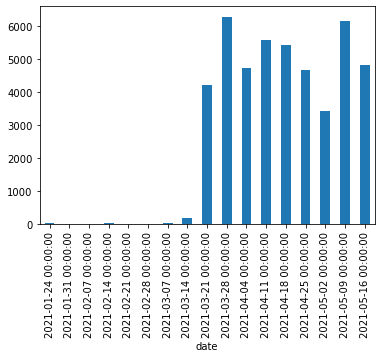

In [8]:
%matplotlib inline
#create a "Date" column from utc and analyze dates
final_df['date'] = final_df['epoch_time'].apply(lambda x: datetime.utcfromtimestamp(x))
print(final_df.groupby(pd.Grouper(key='date',freq='M'))['post_id'].count())
#we see that some values date back to January and February even though we started gathering data at the 18th of March
grouped_weekly_values = final_df.groupby(pd.Grouper(key='date',freq='W'))['post_id'].count()
grouped_weekly_values.plot(kind = 'bar')

In [9]:
#therefore, we want to trim the dataset to begin with date with high frequency to mitigate sampling error
grouped_daily_values = final_df.groupby(pd.Grouper(key='date',freq='D'))['post_id'].count()
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(grouped_daily_values)
#March 17th seems to be a reasonable lower bound for our dataset
final_df = final_df.loc[final_df['date'] >= '2021-03-17']

date
2021-01-18       5
2021-01-19       0
2021-01-20       1
2021-01-21       0
2021-01-22       0
2021-01-23       0
2021-01-24       0
2021-01-25       0
2021-01-26       0
2021-01-27       0
2021-01-28       0
2021-01-29       0
2021-01-30       0
2021-01-31       0
2021-02-01       0
2021-02-02       0
2021-02-03       5
2021-02-04       0
2021-02-05       0
2021-02-06       0
2021-02-07       0
2021-02-08       0
2021-02-09       0
2021-02-10       6
2021-02-11       5
2021-02-12       0
2021-02-13       0
2021-02-14       0
2021-02-15       0
2021-02-16       0
2021-02-17       0
2021-02-18       0
2021-02-19       0
2021-02-20       0
2021-02-21       0
2021-02-22       0
2021-02-23       0
2021-02-24       0
2021-02-25       0
2021-02-26       0
2021-02-27       0
2021-02-28       3
2021-03-01       6
2021-03-02       0
2021-03-03       0
2021-03-04       0
2021-03-05       0
2021-03-06       0
2021-03-07       0
2021-03-08       0
2021-03-09       0
2021-03-10       0
2021-03

In [10]:
#unfortunately, we did not think of the fact that csv saves our list as string 
#so we have to use rgx to make it a list again
def tickers_to_list(string):
    regex = re.compile(r'\'([A-Z]+)\'')
    if string != '':
        tickers = [x.group(1) for x in regex.finditer(string)]
        return tickers
    else:
        return ''
test = tickers_to_list(final_df.iloc[5]['tickers'])
print(type(test))
final_df['tickers'] = final_df['tickers'].apply(tickers_to_list)

print(final_df['tickers'][final_df['tickers'] != ''] )

<class 'list'>
5            [AMD, GOOGL]
11                 [MSFT]
15                  [PSA]
20      [BLL, TSLA, AMZN]
25           [TSLA, AAPL]
              ...        
1494                 [MS]
1508                 [GL]
1513               [NFLX]
1569                [BLK]
1589               [TSLA]
Name: tickers, Length: 7246, dtype: object


In [11]:
z = 0
for i in final_df['tickers']:
    if 'NDAQ' in i:
        z+=1
print(z)

613


In [12]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(final_df[['date','tickers']][final_df['tickers'] != ''])

       [GS]
6    2021-03-26 20:38:23                                             [NDAQ]
17   2021-03-28 18:49:14                                      [DISCA, VIAC]
22   2021-03-28 16:46:38                                             [MSFT]
48   2021-03-28 17:38:49                                             [NDAQ]
49   2021-03-28 17:59:11                                 [TSLA, TWTR, ARKK]
53   2021-03-28 18:22:16                                             [SPGI]
54   2021-03-28 19:14:53                                 [TSLA, AAPL, ARKK]
56   2021-03-28 19:00:37                                             [TWTR]
59   2021-03-28 18:59:54                                               [FB]
96   2021-03-28 18:23:12                                              [GPS]
105  2021-03-28 15:44:35                                             [NDAQ]
107  2021-03-28 17:15:47                                             [SPGI]
124  2021-03-28 08:34:34                                             [ISRG]


In [14]:
#prepare the final dataframe ticker_matrix
date_index = final_df['date'].dt.date.unique()
date_index.sort()
final_df['date'] = final_df['date'].dt.date # we wont need exact intraday time
ticker_matrix = pd.DataFrame(index = date_index)
ticker_matrix.index = pd.to_datetime(ticker_matrix.index)
print(ticker_matrix.index.min())
print(ticker_matrix.index.max()) 
#now we know that the ticker matrix as well as our standardized dataframe share common indexes

2021-03-17 00:00:00
2021-05-16 00:00:00


In [15]:
#with values being the number of mentions for each day
for i in range(len(final_df)):
    row = final_df.iloc[i]
    row_date = row['date']
    if row['tickers'] != '':
        for ticker in row['tickers']: 
            #rowIndex = ticker_matrix.index[row['date']]
            if(ticker not in ticker_matrix.columns): #column already crated
                ticker_matrix[ticker] = pd.Series(dtype='int64')
ticker_matrix = ticker_matrix.fillna(0)

In [16]:
print(ticker_matrix)

            AMD  GOOGL  MSFT  PSA  BLL  TSLA  AMZN  AAPL  NDAQ  DOW  ...  IFF  \
2021-03-17  0.0    0.0   0.0  0.0  0.0   0.0   0.0   0.0   0.0  0.0  ...  0.0   
2021-03-18  0.0    0.0   0.0  0.0  0.0   0.0   0.0   0.0   0.0  0.0  ...  0.0   
2021-03-19  0.0    0.0   0.0  0.0  0.0   0.0   0.0   0.0   0.0  0.0  ...  0.0   
2021-03-20  0.0    0.0   0.0  0.0  0.0   0.0   0.0   0.0   0.0  0.0  ...  0.0   
2021-03-21  0.0    0.0   0.0  0.0  0.0   0.0   0.0   0.0   0.0  0.0  ...  0.0   
...         ...    ...   ...  ...  ...   ...   ...   ...   ...  ...  ...  ...   
2021-05-12  0.0    0.0   0.0  0.0  0.0   0.0   0.0   0.0   0.0  0.0  ...  0.0   
2021-05-13  0.0    0.0   0.0  0.0  0.0   0.0   0.0   0.0   0.0  0.0  ...  0.0   
2021-05-14  0.0    0.0   0.0  0.0  0.0   0.0   0.0   0.0   0.0  0.0  ...  0.0   
2021-05-15  0.0    0.0   0.0  0.0  0.0   0.0   0.0   0.0   0.0  0.0  ...  0.0   
2021-05-16  0.0    0.0   0.0  0.0  0.0   0.0   0.0   0.0   0.0  0.0  ...  0.0   

            WEC  XYL  SLG  

In [17]:
#now we create matrix with rows as days and columns as ticker mentions,
#with values being the number of mentions for each day
for i in range(len(final_df)):
    row = final_df.iloc[i]
    row_date = row['date']
    if row['tickers'] != '':
        for ticker in row['tickers']: 
            ticker_matrix.loc[[row_date],[ticker]] += 1 #add mention

In [18]:
print(ticker_matrix)

             AMD  GOOGL  MSFT  PSA  BLL  TSLA  AMZN  AAPL  NDAQ  DOW  ...  \
2021-03-17   4.0    5.0   3.0  0.0  0.0   9.0   8.0  15.0   4.0  1.0  ...   
2021-03-18  10.0    8.0   8.0  0.0  3.0  16.0  21.0  23.0  16.0  4.0  ...   
2021-03-19  13.0   16.0   7.0  1.0  2.0  35.0  13.0  24.0  23.0  5.0  ...   
2021-03-20   5.0    6.0   5.0  0.0  3.0  19.0  13.0  13.0   9.0  3.0  ...   
2021-03-21   2.0    7.0  20.0  0.0  0.0  23.0  15.0  19.0   4.0  1.0  ...   
...          ...    ...   ...  ...  ...   ...   ...   ...   ...  ...  ...   
2021-05-12   6.0    9.0  10.0  0.0  1.0  24.0  13.0  15.0  14.0  6.0  ...   
2021-05-13   4.0    7.0  11.0  0.0  1.0  26.0   8.0  19.0  14.0  4.0  ...   
2021-05-14   5.0    2.0   4.0  0.0  1.0  15.0   4.0  11.0   8.0  3.0  ...   
2021-05-15   4.0    9.0   7.0  0.0  1.0   8.0  10.0   4.0   6.0  0.0  ...   
2021-05-16   2.0    8.0   3.0  0.0  3.0   9.0   5.0   4.0   0.0  0.0  ...   

            IFF  WEC  XYL  SLG  NWL  WRK  RMD  VTR  ROST  LNC  
2021-03-17 

In [19]:
#
#check if every column has non-zero values
print(ticker_matrix.apply(lambda x: (x != 0).any()).all())
#check top mentions
print(ticker_matrix.apply(max).sort_values(ascending = False).head())
#check days with msot mentions
print(ticker_matrix.apply(sum,axis = 1).sort_values(ascending = False).head())

True
TSLA    41.0
MSFT    38.0
AAPL    29.0
AMD     25.0
AMZN    25.0
dtype: float64
2021-03-23    446.0
2021-03-24    382.0
2021-03-29    361.0
2021-03-19    354.0
2021-05-07    353.0
dtype: float64


In [33]:
#we do not want to work with tickers mentioned only once as that is too small of a dataset, so we leave these out
above_one = ticker_matrix.apply(sum,axis = 0)>1
print(above_one)
trimmed_df = ticker_matrix[above_one.index[above_one]]#['NDAQ']
print(trimmed_df)   

AMD       True
GOOGL     True
MSFT      True
PSA       True
BLL       True
         ...  
WRK      False
RMD      False
VTR       True
ROST     False
LNC      False
Length: 417, dtype: bool
             AMD  GOOGL  MSFT  PSA  BLL  TSLA  AMZN  AAPL  NDAQ  DOW  ...  \
2021-03-17   4.0    5.0   3.0  0.0  0.0   9.0   8.0  15.0   4.0  1.0  ...   
2021-03-18  10.0    8.0   8.0  0.0  3.0  16.0  21.0  23.0  16.0  4.0  ...   
2021-03-19  13.0   16.0   7.0  1.0  2.0  35.0  13.0  24.0  23.0  5.0  ...   
2021-03-20   5.0    6.0   5.0  0.0  3.0  19.0  13.0  13.0   9.0  3.0  ...   
2021-03-21   2.0    7.0  20.0  0.0  0.0  23.0  15.0  19.0   4.0  1.0  ...   
...          ...    ...   ...  ...  ...   ...   ...   ...   ...  ...  ...   
2021-05-12   6.0    9.0  10.0  0.0  1.0  24.0  13.0  15.0  14.0  6.0  ...   
2021-05-13   4.0    7.0  11.0  0.0  1.0  26.0   8.0  19.0  14.0  4.0  ...   
2021-05-14   5.0    2.0   4.0  0.0  1.0  15.0   4.0  11.0   8.0  3.0  ...   
2021-05-15   4.0    9.0   7.0  0.0  1.0 

In [34]:
print(trimmed_df.shape)
trimmed_df.loc[:,'VTR'].sum()

(61, 375)


2.0

In [24]:
trimmed_df.to_csv('model_data.csv',header=True)